## Traininig of the High Level Feature classifier with Pytorch

**4.0 PyTorch, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses Pytorch on a single node. Pandas is used to read the data and pass it to PyTorch.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Load train and test datasets via Pandas

In [1]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

import pandas as pd

testPDF = pd.read_parquet(path= PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPDF = pd.read_parquet(path= PATH + 'trainUndersampled_HLF_features.parquet', 
                           columns=['HLF_input', 'encoded_label'])

INFO:SparkMonitorKernel:SparkMonitor comm opened from frontend.


In [2]:
# Check the number of events in the train and test datasets

num_test = testPDF.count()
num_train = trainPDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are HLF_input        856090
encoded_label    856090
dtype: int64 events in the test dataset
There are HLF_input        3426083
encoded_label    3426083
dtype: int64 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPDF


,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"
...,...,...
856085,"[0.020383967386165446, 0.0022348975484913444, ...","[0.0, 1.0, 0.0]"
856086,"[0.02475209699743233, 0.00867502196073073, 0.3...","[0.0, 1.0, 0.0]"
856087,"[0.03498179428310887, 0.02506331737284528, 0.9...","[0.0, 1.0, 0.0]"
856088,"[0.03735147362869153, 0.003645269183639405, 0....","[0.0, 1.0, 0.0]"


## Convert training and test datasets from Pandas DataFrames to Numpy arrays

Now we will collect and convert the Pandas DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.


In [4]:
import numpy as np

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])

## Create PyTorch model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

torch.__version__

'2.3.1'

In [6]:
torch.cuda.is_available()

True

In [7]:
class Net(nn.Module):
    def __init__(self, nh_1, nh_2, nh_3):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, nh_1)
        self.fc2 = nn.Linear(nh_1, nh_2)
        self.fc3 = nn.Linear(nh_2, nh_3)
        self.fc4 = nn.Linear(nh_3, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        output = nn.functional.softmax(self.fc4(x), dim=1)
        return output

def create_model(nh_1, nh_2, nh_3):
    model = Net(nh_1, nh_2, nh_3)
    return model


## Train the model

In [8]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return(test_loss, test_accuracy)


In [9]:
def train(model, device, train_loader, optimizer, epoch):
    log_interval = 10000
    model.train()
    correct = 0
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        # metrics
        running_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        target = target.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        #
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader.dataset), loss.item()))

    # train_loss = loss.item()
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    print('\nTrain set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset), train_accuracy))

    return(train_loss, train_accuracy)

In [10]:
torch.manual_seed(1)

# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 1000}
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': False}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

# Map train and test data to Pytorch's dataloader
train_tensor = TensorDataset(torch.Tensor(X),torch.Tensor(y))
test_tensor =  TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test))
train_loader = torch.utils.data.DataLoader(train_tensor, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_tensor, **test_kwargs)
   
model = create_model(50,20,10).to(device)
optimizer = optim.Adam(model.parameters())


In [11]:
def train_loop():
    gamma = 0.7
    epochs = 5
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    hist = {}
    hist['loss'] = []
    hist['accuracy'] = []
    hist['val_loss'] = []
    hist['val_accuracy'] = []
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        val_loss, val_accuracy = test(model, device, test_loader)
        scheduler.step()
        hist['loss'] += [train_loss]
        hist['accuracy'] += [train_accuracy]
        hist['val_loss'] += [val_loss]
        hist['val_accuracy'] += [val_accuracy]
    return(hist)


In [12]:
%time hist = train_loop()

Train Epoch: 1 [0/3426083 (0%)]	Loss: 1.107895
Train Epoch: 1 [1280000/3426083 (0%)]	Loss: 0.637833
Train Epoch: 1 [2560000/3426083 (1%)]	Loss: 0.669610

Train set: Loss: 0.6617, Accuracy: 3041072/3426083 (89%)

Test set: Average loss: 0.6525, Accuracy: 767865/856090 (90%)

Train Epoch: 2 [0/3426083 (0%)]	Loss: 0.661275
Train Epoch: 2 [1280000/3426083 (0%)]	Loss: 0.621742
Train Epoch: 2 [2560000/3426083 (1%)]	Loss: 0.650002

Train set: Loss: 0.6456, Accuracy: 3096063/3426083 (90%)

Test set: Average loss: 0.6431, Accuracy: 775943/856090 (91%)

Train Epoch: 3 [0/3426083 (0%)]	Loss: 0.654063
Train Epoch: 3 [1280000/3426083 (0%)]	Loss: 0.619024
Train Epoch: 3 [2560000/3426083 (1%)]	Loss: 0.653076

Train set: Loss: 0.6426, Accuracy: 3106522/3426083 (91%)

Test set: Average loss: 0.6413, Accuracy: 777551/856090 (91%)

Train Epoch: 4 [0/3426083 (0%)]	Loss: 0.654626
Train Epoch: 4 [1280000/3426083 (0%)]	Loss: 0.619553
Train Epoch: 4 [2560000/3426083 (1%)]	Loss: 0.657368

Train set: Loss: 0.64

## Performance metrics

<IPython.core.display.Javascript object>


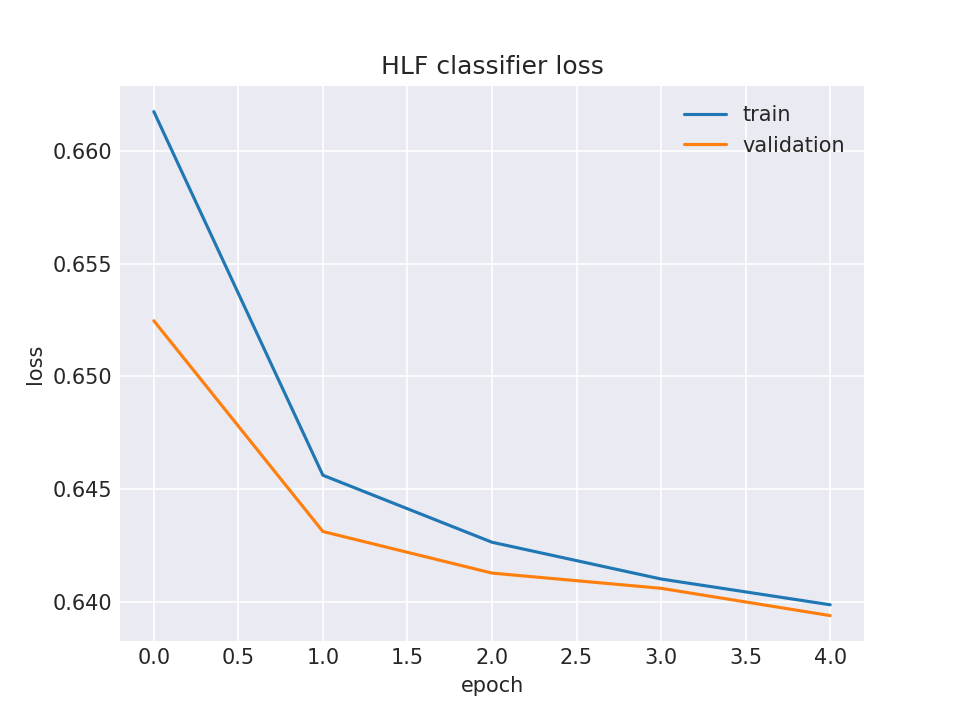

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


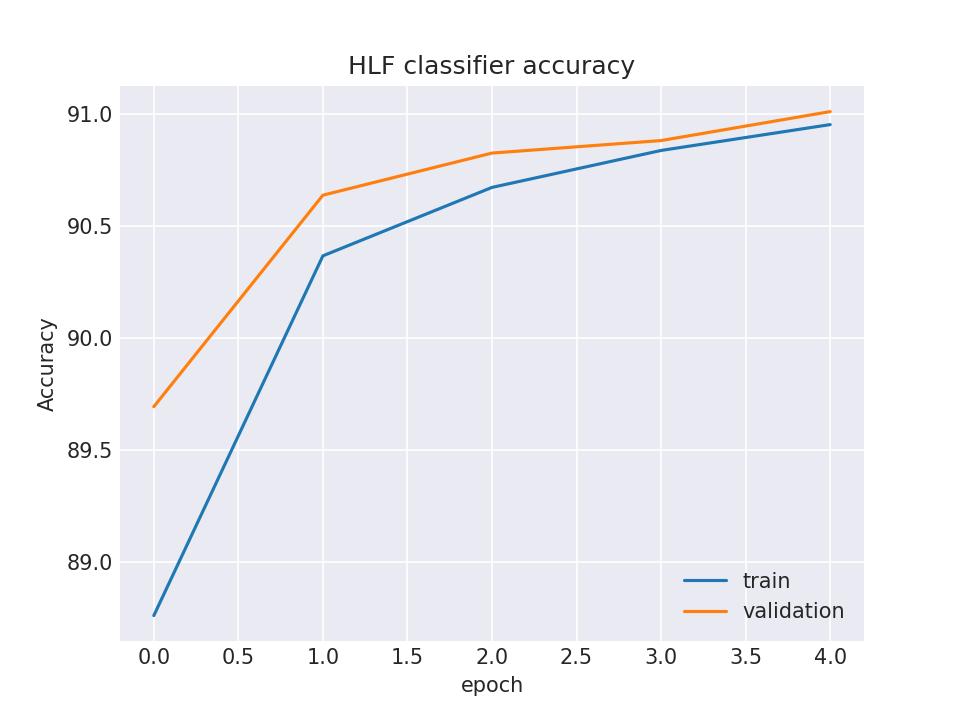

In [14]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [15]:
with torch.no_grad():
    # predicted values
    y_pred = np.concatenate([model(data.to(device)).cpu().numpy() for data, target in test_loader])
    # test labels
    y_true = np.concatenate([target.cpu().numpy() for data, target in test_loader])

In [16]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9101


<IPython.core.display.Javascript object>


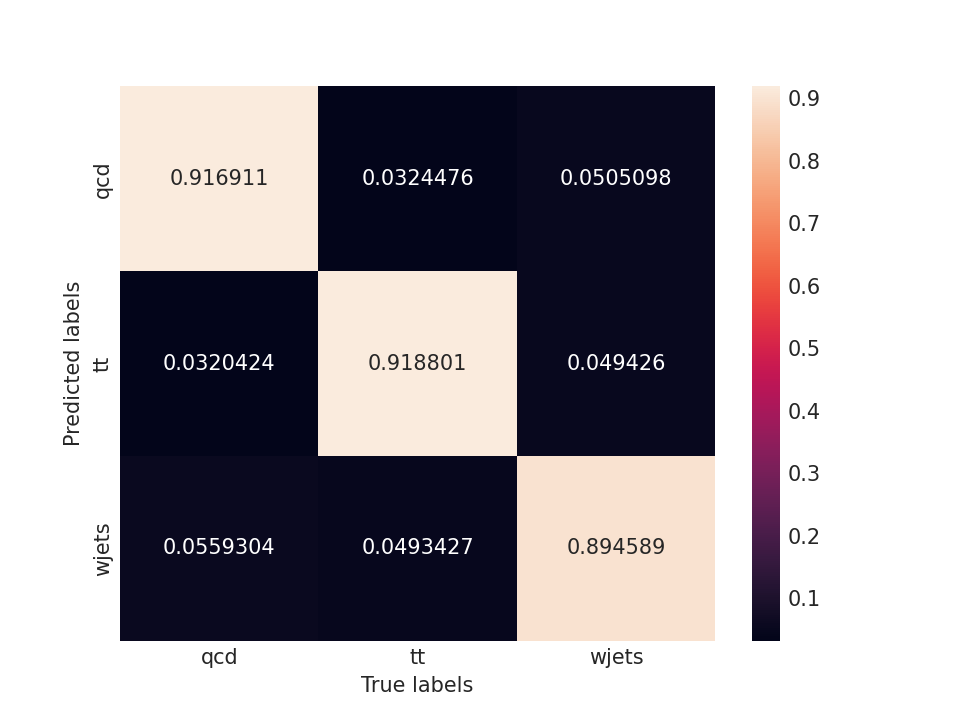

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [19]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [20]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.984458505956827, 1: 0.9783169321933833, 2: 0.9749204304258697}

<IPython.core.display.Javascript object>


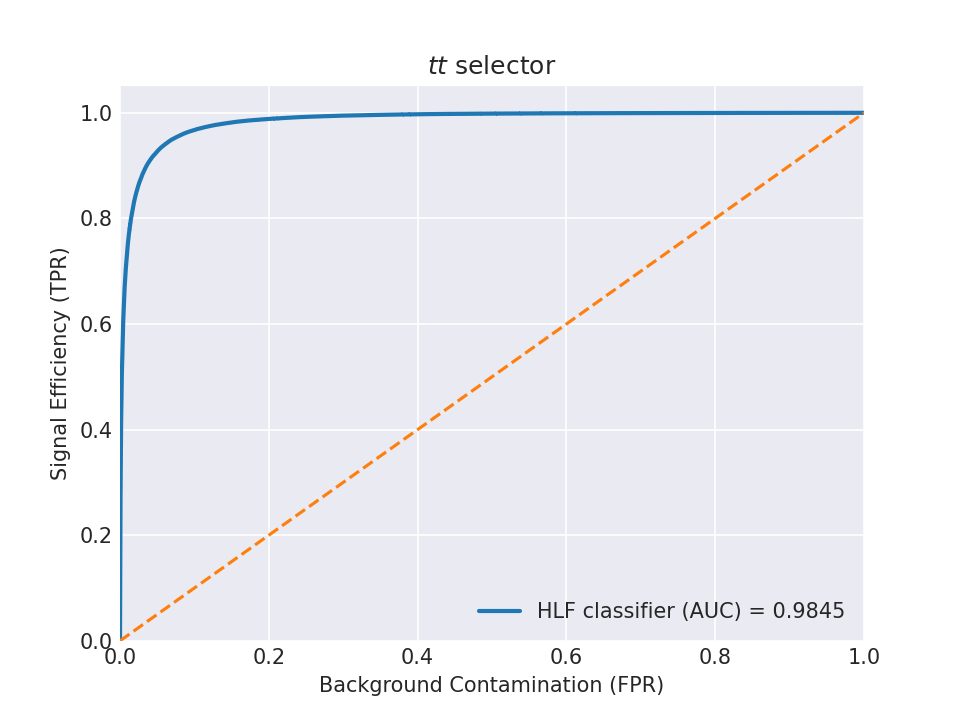

In [21]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()